In [1]:
import gym
import torch
import gym_nav
import numpy as np

import sys
sys.path.append('../')
from evaluation import *
from model_evaluation import *
from trajectories import *
from shortcut_analysis import *
from explore_analysis import *
from plotting_utils import *
from read_experiments import *

from tqdm import tqdm
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from pathlib import Path
import shutil

set_rc()

# chk_sched to plot with
chks1 = np.arange(0, 150, 10) #0-1e6
chks2 = np.arange(160, 300, 20) #1e6-2e6
chks3 = np.arange(300, 600, 40) #2e6-4e6
chks4 = np.arange(620, 930, 60) #4e6-6e6
chk_sched = np.concatenate([chks1, chks2, chks3, chks4])

# Note actual folders are suffixed with _policy and _copied
wsns_data = {
    'control': {
        'tasks':  [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0],
        'labels': [f'p={p}' for p in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]],
        'folder_prefix': 'wc1.5',
    },
    'aux': { # Auxiliary tasks
        'tasks': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
        'labels': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
        'folder_prefix': 'sc_aux',
    },
    'pre': { # Pretraining tasks
        'tasks':  ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1'],
        'labels': ['Plum Shortcut p=0.1', 'Plum Shortcut p=0.4', 'Plum Grid', 'Plum Maze'],
        'folder_prefix': 'plum2sc',
    },
    'scwplum': {
        'tasks': [0.1],
        'labels': ['p=0.1 with Plum start'],
        'folder_prefix': 'scwplum'
    }
}

save = Path('plots/')

# Environment drawings

Drawings of what different environments and training conditions look like

meta NOT subset; don't know how to subset; dropped


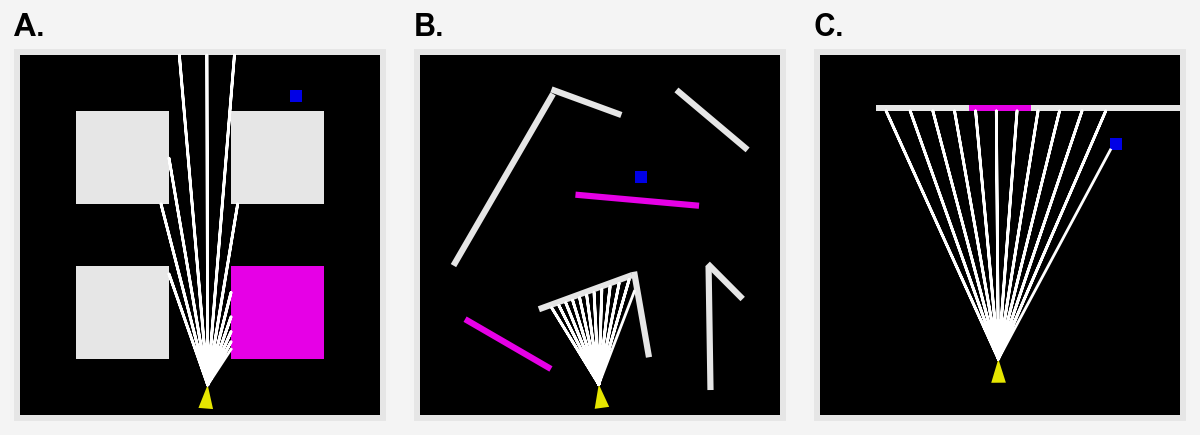

In [58]:
set_trajectory_plot_style()

fig, ax = pplt.subplots(ncols=3, figwidth=6)

tasks = [1.7, 2.7, 3]
p = 0

np.random.seed(0)
for i, task in enumerate(tasks):
    env = gym.make('PlumNav-v0', task_structure=task, 
                   shortcut_probability=p, num_plums=1,
                   wall_thickness=5)
    env.reset()
    env.character.size = 20
    env.render('human', ax=ax[i])
    
    
ax.format(xlim=[0, 300], ylim=[0, 300], abc='A.')
set_rc()

fig.savefig(save/'1_pretraining_envs')

# Learning curves and control performance

Used for first results section of learning curves

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


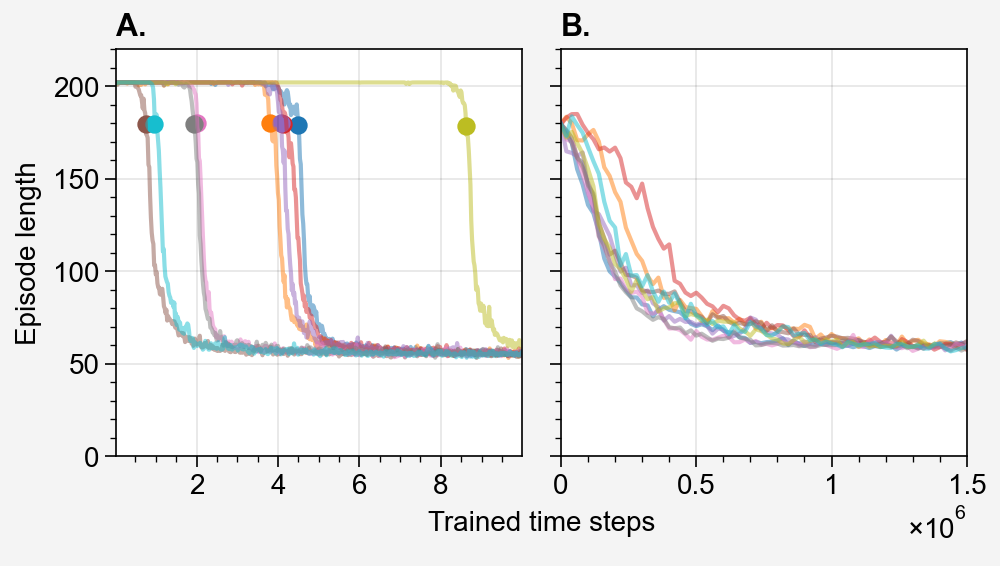

In [13]:
exp_format = 'shortcut_wc1.5p0.1longer_t{t}'
cont_format = 'shortcut_wc1.5p0.1longer_cont_t{t}'

fig, ax = pplt.subplots(ncols=2, figwidth=5)
for i in range(10):
    df = combine_cont_df(exp_format, cont_format, formatter={'t': i},)
    x, y = get_run_df_metric(df)
    first = get_first_shortcut_performance(x, y, ret_chk=False)
    
    
    if not first:
        continue
    ax[0].plot(x[::100]/1000000, y[::100], color=rgb_colors[i], alpha=0.5)
    ax[0].scatter([x[first]/1000000], [y[first]], color=rgb_colors[i])
    
    ax[1].plot(x[first:][::100]-x[first], y[first:][::100], color=rgb_colors[i], alpha=0.5)
    
    
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          # title=['Original Learning Curve', 'Shifted Learning Curve'],
         abc='A.',
         ylim=[0, 220])
ax[0].format(xlocator=[0, 2, 4, 6, 8])
ax[1].format(xlocator=np.array([0, 0.5, 1, 1.5])*1e6,
            xlim=[0, 1.5e6])

fig.savefig(save/'2_p01_shifted_learning_curves')


## p Training performance curves

meta NOT subset; don't know how to subset; dropped


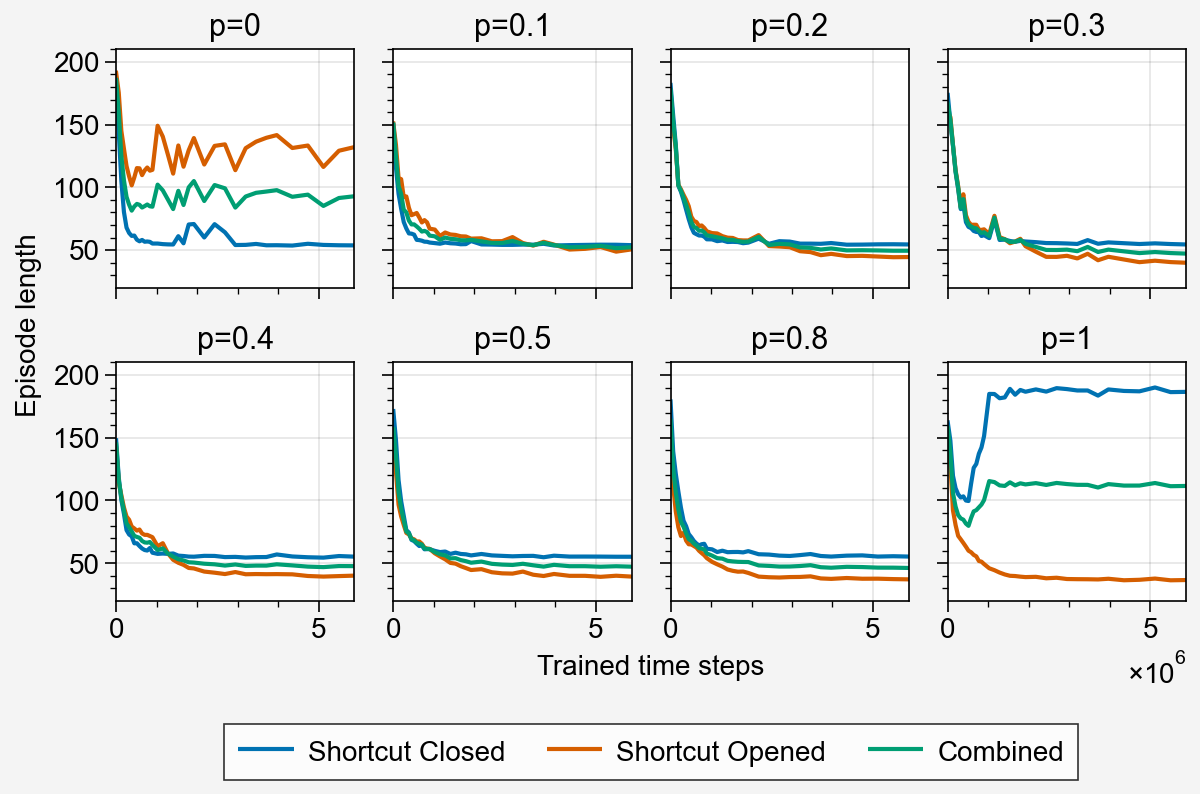

In [61]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    lines = []
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
    if p == 0.1:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][8]
    
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='Shortcut Closed'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='Shortcut Opened'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in prob_labels], ylim=[20, 210])
fig.savefig(save/'2_1_p_performance_curves')

meta NOT subset; don't know how to subset; dropped


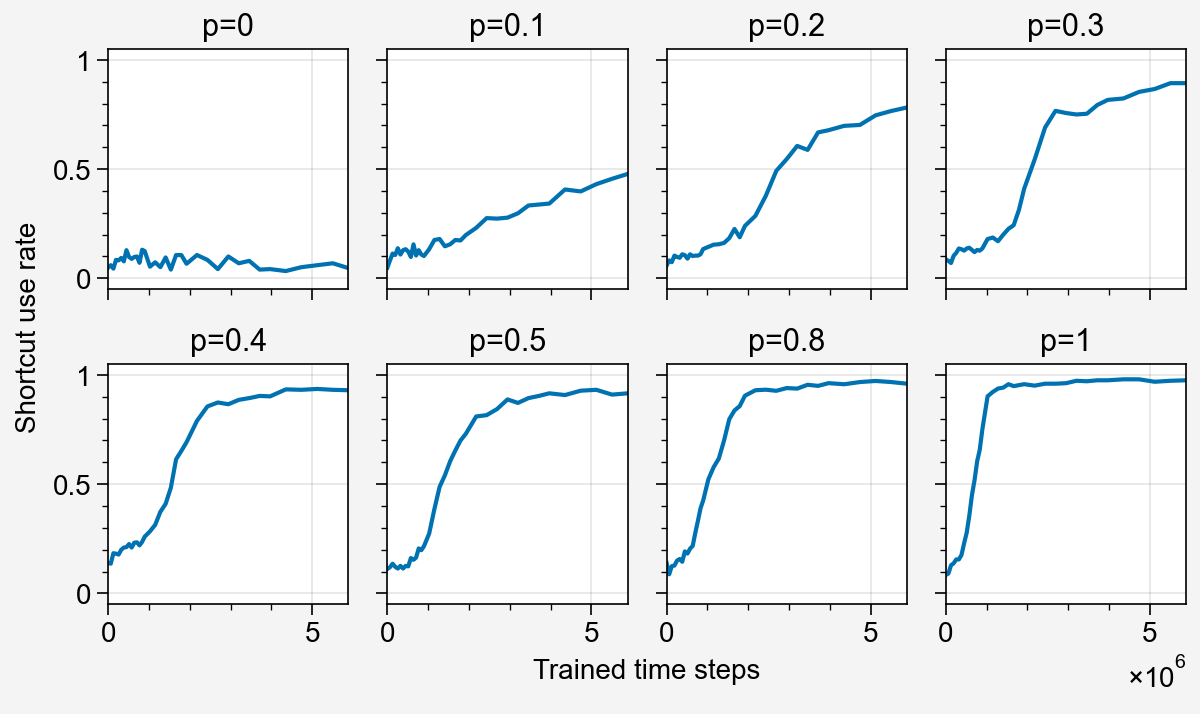

In [62]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]

trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

del summary[0.3]['surs'][2]
del summary[0.1]['surs'][8]

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000

    lines = []
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['surs'], axis=0), label='Shortcut use rate'))

ax.format(xlabel='Trained time steps', ylabel='Shortcut use rate',
          title=[f'p={p}' for p in prob_labels], ylim=[-0.05, 1.05])
fig.savefig(save/'2_1_p_shortcut_use_curves')

meta NOT subset; don't know how to subset; dropped


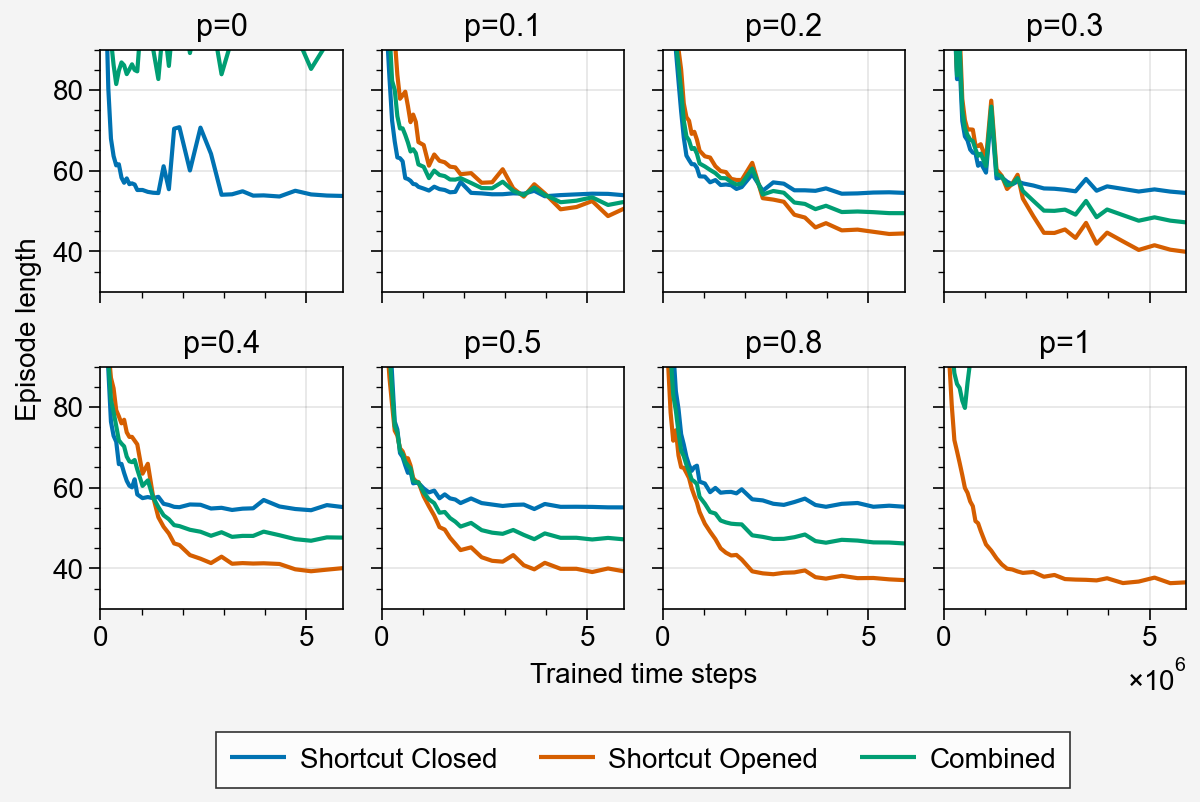

In [63]:
probs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0]
prob_labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1]
trials = range(10)
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=4, figwidth=6)

x = chk_sched * 64 * 100
for i, p in enumerate(probs):
    lines = []
    x_plot = x
    if i in [0, 1, 2, 4, 5, 6]:
        x_plot = x_plot / 1000000
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
    if p == 0.1:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][8]
    
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ns_lens'], axis=0), label='Shortcut Closed'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['ws_lens'], axis=0), label='Shortcut Opened'))
    lines.append(ax[i].plot(x_plot, np.mean(summary[p]['comb_lens'], axis=0), label='Combined'))

fig.legend(lines, loc='b')
ax.format(xlabel='Trained time steps', ylabel='Episode length',
          title=[f'p={p}' for p in prob_labels], ylim=[30, 90])
fig.savefig(save/'2_1_p_performance_curves_zoomed')

## Comparison of open vs closed performancce and relation to shortcut use

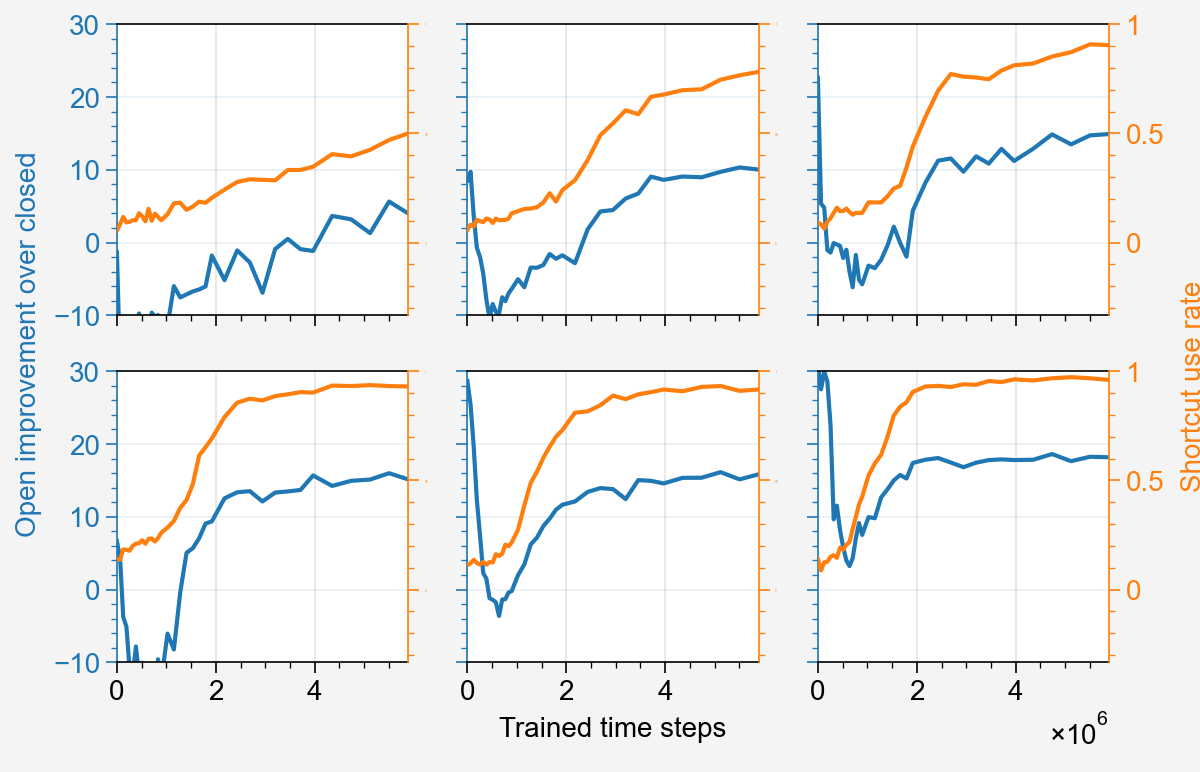

In [64]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]

fig, ax = pplt.subplots(nrows=2, ncols=3, figwidth=6)
sax = ax.dualy(lambda x: x / 30)

for i, p in enumerate(probs):
    x = [] # ws vs ns difference
    y = [] # sur
    
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
    if p == 0.1:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][8]


    diff = np.array(summary[p]['ns_lens']) - np.array(summary[p]['ws_lens'])
    y1 = diff.mean(axis=0)
    y2 = np.mean(summary[p]['surs'], axis=0)
    
    x = chk_sched * 64 * 100
    if i in [0, 1, 3, 4]:
        x = x / 1000000

    ax[i].plot(x, y1, c=rgb_colors[0])
    sax[i].plot(x, y2, c=rgb_colors[1])

ax.format(ylabel='Open improvement over closed', ylabelcolor=rgb_colors[0], ylim=[-10, 30],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps')
sax.format(ylabelcolor=rgb_colors[1],
          ytickcolor=rgb_colors[1], yticklabelcolor=rgb_colors[1], ygridcolor=rgb_colors[1])

for a in ax:
    a.spines['left'].set_color(rgb_colors[0])
for a in sax:
    a.spines['right'].set_color(rgb_colors[1])

fig.text(0.995, 0.5, 'Shortcut use rate', rotation=90, 
         transform=fig.transFigure, ha='center',
         va='center', color=rgb_colors[1]
)
sax[:, :2].format(fontsize=0)

meta NOT subset; don't know how to subset; dropped


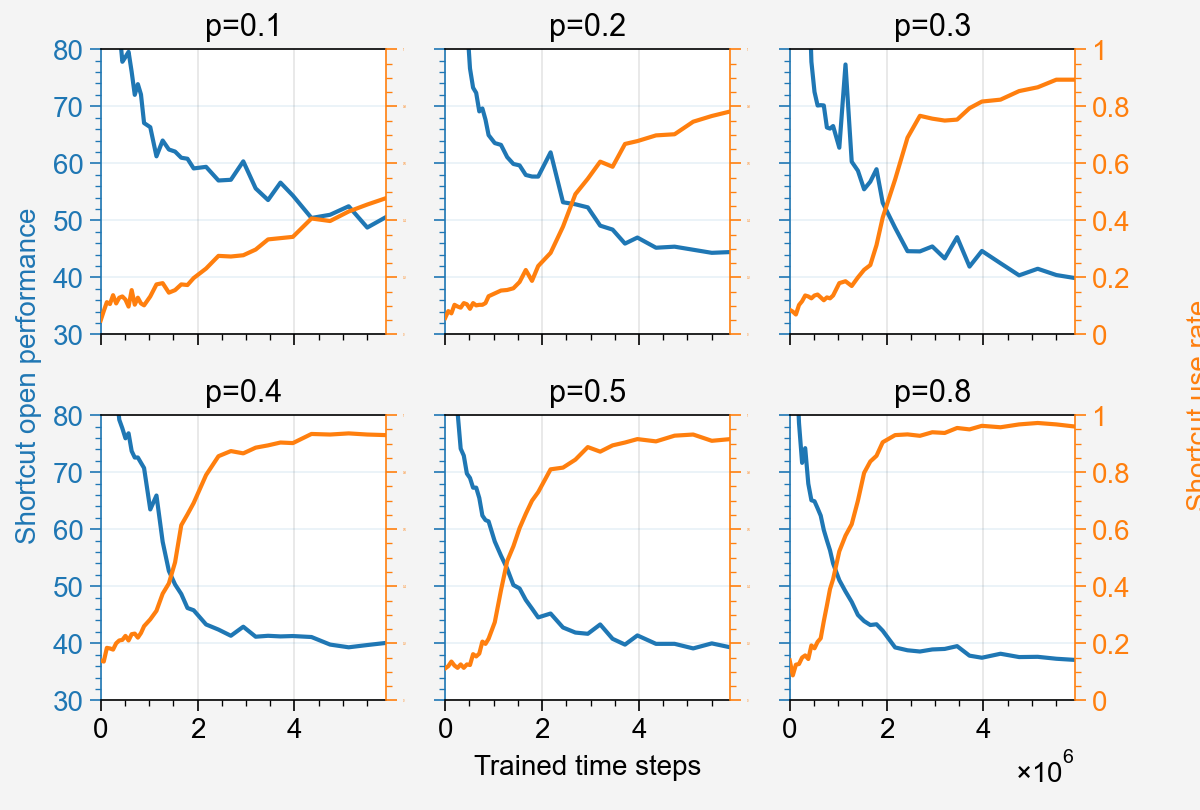

In [65]:
probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.8]
folder = Path('data/shortcut/wc1.5_policy')

summary = pickle.load(open(folder/'summary', 'rb'))

fig, ax = pplt.subplots(nrows=2, ncols=3, figwidth=6)
sax = ax.dualy(lambda x: (x-30) / 50)

for i, p in enumerate(probs):
    x = chk_sched * 64 * 100
    if i in [0, 1, 3, 4]:
        x = x / 1000000
    if p == 0.3:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][2]
    if p == 0.1:
        for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
            del summary[p][key][8]
    y0 = np.mean(summary[p]['ws_lens'], axis=0)
    y1 = np.mean(summary[p]['surs'], axis=0)

    ax[i].plot(x, y0, c=rgb_colors[0], label='Shortcut Closed')
    sax[i].plot(x, y1, c=rgb_colors[1])

ax.format(ylabel='Shortcut open performance', ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps',
          ylim=[30, 80], title=[f'p={p}' for p in probs])
sax.format(ylabelcolor=rgb_colors[1],
          ytickcolor=rgb_colors[1], yticklabelcolor=rgb_colors[1], ygridcolor=rgb_colors[1])

for a in ax:
    a.spines['left'].set_color(rgb_colors[0])
for a in sax:
    a.spines['right'].set_color(rgb_colors[1])

fig.text(1, 0.5, 'Shortcut use rate', rotation=90, 
         transform=fig.transFigure, ha='center',
         va='center', color=rgb_colors[1]
)
sax[:, :2].format(fontsize=0)
fig.savefig(save/'2_2_open_performance_sur')

## Performance and shortcut use rate with pre-training and auxiliary

meta NOT subset; don't know how to subset; dropped


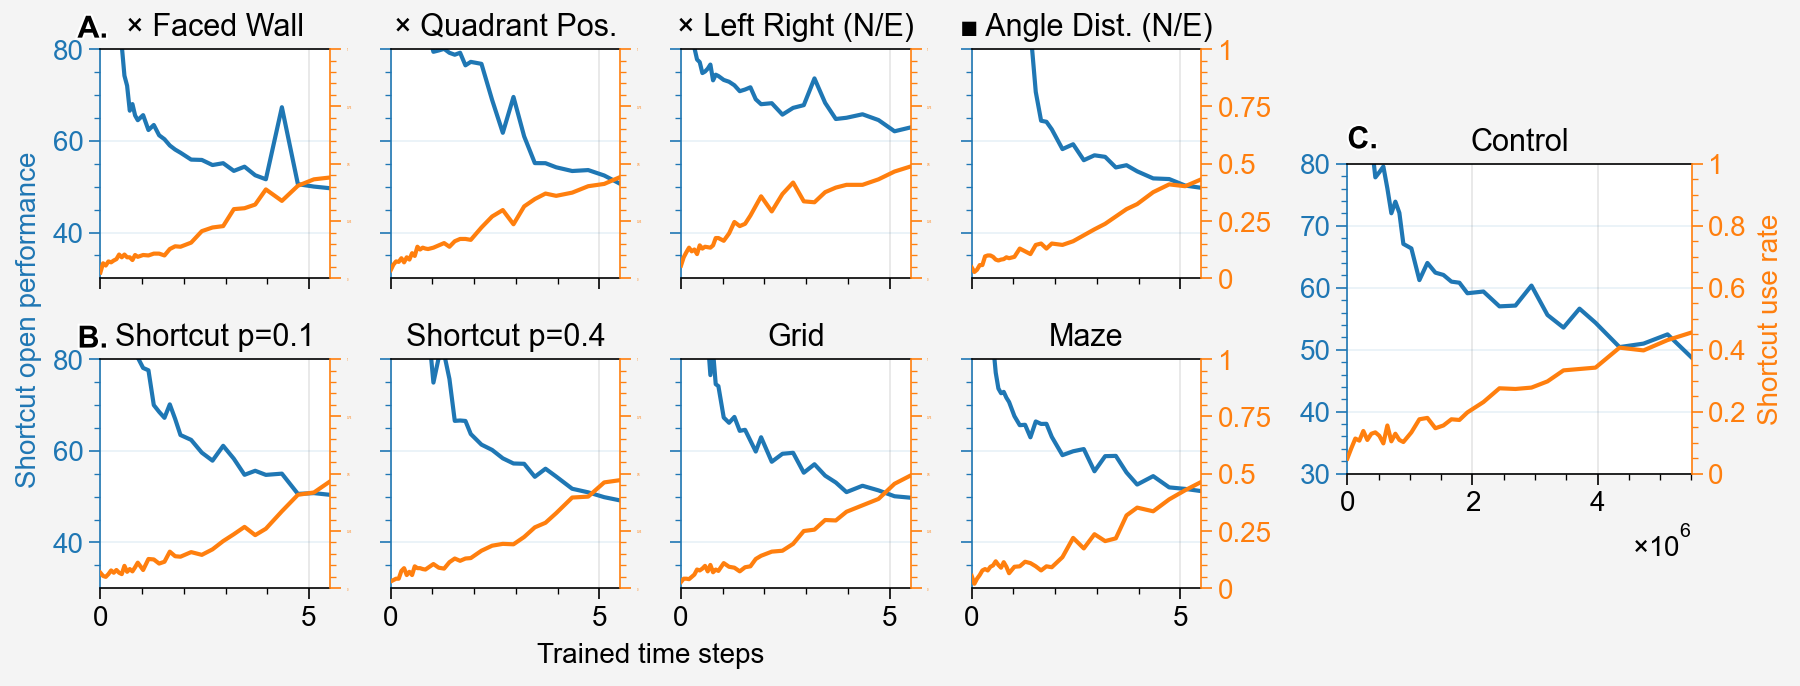

In [66]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['catfacewall',  'catquad', 'catwall01', 'wall01'],
    'pre': ['3_0.1_0.1', '3_0.4_0.1', '1.7_0.1', '2.7_0.1']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

array = [
    [1,1, 2,2, 3,3, 4,4, 0,0,0],
    [1,1, 2,2, 3,3, 4,4, 9,9,9],
    [5,5, 6,6, 7,7, 8,8, 9,9,9],
    [5,5, 6,6, 7,7, 8,8, 0,0,0],
]

fig, axs = pplt.subplots(array, figwidth=9)
saxs = []
all_labels = []

for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'summary', 'rb'))
    
    for j in range(4):
        ax = axs[i*4 + j]
        sax = ax.dualy(lambda x: (x-30)/50)
        saxs.append(sax)
        subset = subsets[train][j]
        all_labels.append(labels[train][j])
        
        x = chk_sched * 64 * 100 / 1000000
        y0 = np.mean(summary[subset]['ws_lens'], axis=0)
        y1 = np.mean(summary[subset]['surs'], axis=0)
        
        ax.plot(x[:35], y0, c=rgb_colors[0])
        sax.plot(x[:35], y1, c=rgb_colors[1])
        
        sax.format(ycolor=rgb_colors[1])
        if j < 3:
            sax.format(fontsize=0)

        
# Plot control

folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))

ax = axs[8]
sax = ax.dualy(lambda x: (x-30)/50)
saxs.append(sax)
x = chk_sched*64*100
p = 0.1
for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
    del summary[p][key][8]
y0 = np.mean(summary[p]['ws_lens'], axis=0)
y1 = np.mean(summary[p]['surs'], axis=0)
all_labels.append('Control')

ax.plot(x[:35], y0[:35], c=rgb_colors[0])
sax.plot(x[:35], y1[:35], c=rgb_colors[1])

sax.format(ycolor=rgb_colors[1], ylabel='Shortcut use rate')
axs.format(ylabel='Shortcut open performance', ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps',
          ylim=[30, 80], title=all_labels)
axs.format(ycolor=list(rgb_colors[0]))
axs[-1].format(ylabel='', xlabel='')

for a in axs:
    a.spines['left'].set_color(rgb_colors[0])
for a in saxs:
    a.spines['right'].set_color(rgb_colors[1])

add_abc_to_subaxes(axs[0], 'A.', left=-0.1)
add_abc_to_subaxes(axs[4], 'B.', left=-0.1)
add_abc_to_subaxes(axs[-1], 'C.')
    
fig.savefig(save/'2_3_intervention_open_sur')

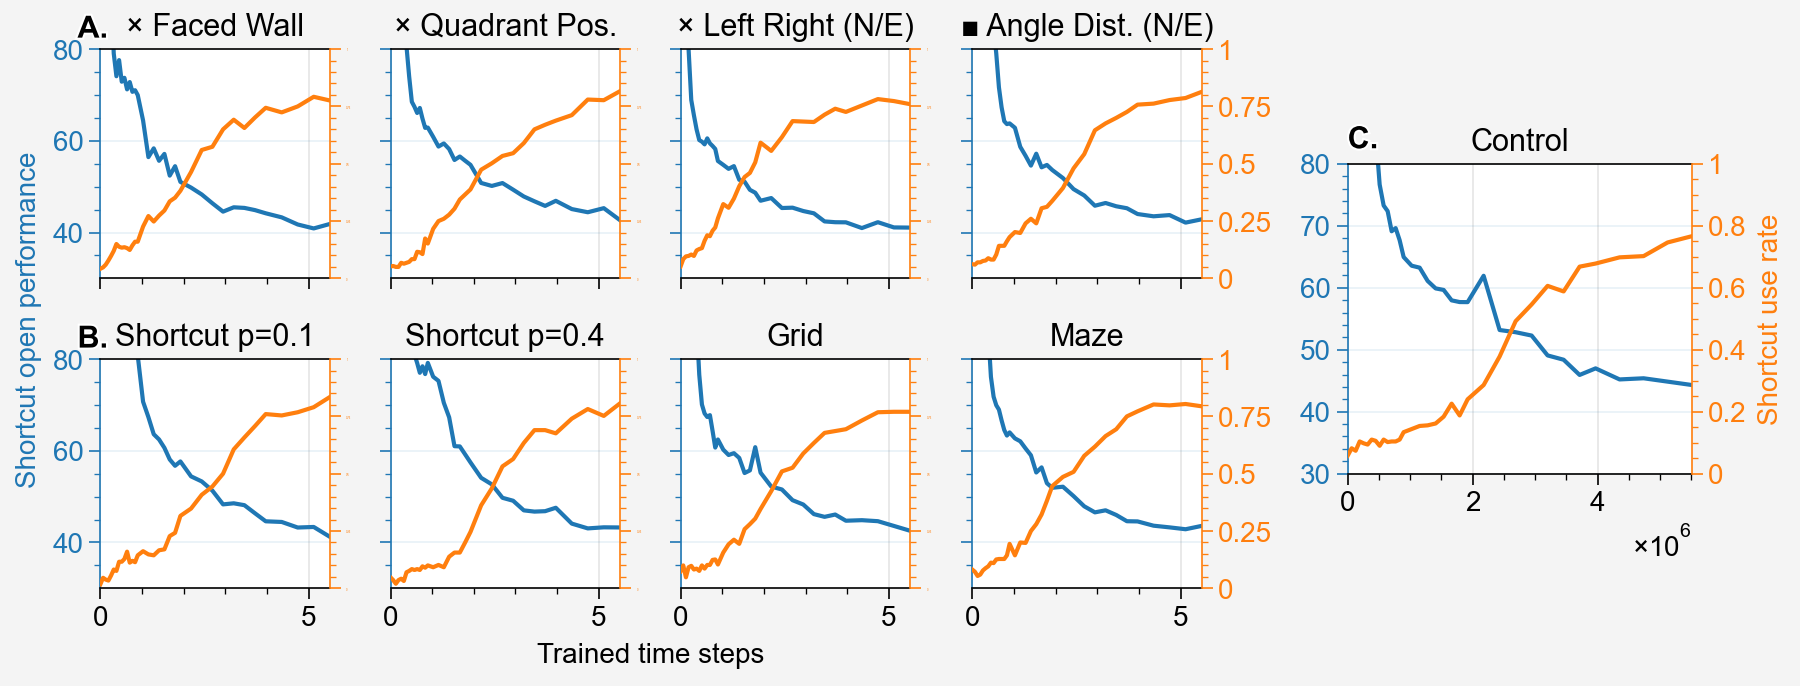

In [16]:
folders = {
    'aux': Path('data/shortcut/sc_aux_policy'),
    'pre': Path('data/shortcut/plum2sc_policy')
}

subsets = {
    'aux': ['0.2_catfacewall',  '0.2_catquad', '0.2_catwall01', '0.2_wall01'],
    'pre': ['3tp0.1_0.2', '3tp0.4_0.2', '1.7_0.2', '2.7_0.2']
}

labels = {
    'aux': [u'\u00D7 Faced Wall', u'\u00D7 Quadrant Pos.',
          u'\u00D7 Left Right (N/E)', '\u25A0 Angle Dist. (N/E)'],
    'pre': ['Shortcut p=0.1', 'Shortcut p=0.4', 'Grid', 'Maze']
}

train_types = ['aux', 'pre']

array = [
    [1,1, 2,2, 3,3, 4,4, 0,0,0],
    [1,1, 2,2, 3,3, 4,4, 9,9,9],
    [5,5, 6,6, 7,7, 8,8, 9,9,9],
    [5,5, 6,6, 7,7, 8,8, 0,0,0],
]

fig, axs = pplt.subplots(array, figwidth=9)
saxs = []
all_labels = []

for i, train in enumerate(train_types):
    summary = pickle.load(open(folders[train]/'0.2_summary', 'rb'))
    
    for j in range(4):
        ax = axs[i*4 + j]
        sax = ax.dualy(lambda x: (x-30)/50)
        saxs.append(sax)
        subset = subsets[train][j]
        all_labels.append(labels[train][j])
        
        x = chk_sched * 64 * 100 / 1000000
        ys = np.full((10, 36), np.nan)
        max_len = max([len(s) for s in summary[subset]['ws_lens']])
        for n, s in enumerate(summary[subset]['ws_lens']):
            ys[n][:len(s)] = s
        y0 = np.nanmean(ys[:, :max_len], axis=0)
        ys = np.full((10, 36), np.nan)
        max_len = max([len(s) for s in summary[subset]['surs']])
        for n, s in enumerate(summary[subset]['surs']):
            ys[n][:len(s)] = s
        y1 = np.nanmean(ys[:, :max_len], axis=0)
        
        ax.plot(x[:len(y0)], y0, c=rgb_colors[0])
        sax.plot(x[:len(y1)], y1, c=rgb_colors[1])
        
        sax.format(ycolor=rgb_colors[1])
        if j < 3:
            sax.format(fontsize=0)

        
# Plot control

folder = Path('data/shortcut/wc1.5_policy')
summary = pickle.load(open(folder/'summary', 'rb'))

ax = axs[8]
sax = ax.dualy(lambda x: (x-30)/50)
saxs.append(sax)
x = chk_sched*64*100
p = 0.2
# for key in ['ns_lens', 'ws_lens', 'comb_lens', 'surs']:
#     del summary[p][key][8]
y0 = np.mean(summary[p]['ws_lens'], axis=0)
y1 = np.mean(summary[p]['surs'], axis=0)
all_labels.append('Control')

ax.plot(x[:35], y0[:35], c=rgb_colors[0])
sax.plot(x[:35], y1[:35], c=rgb_colors[1])

sax.format(ycolor=rgb_colors[1], ylabel='Shortcut use rate')
axs.format(ylabel='Shortcut open performance', ylabelcolor=rgb_colors[0],
          ytickcolor=rgb_colors[0], yticklabelcolor=rgb_colors[0], ygridcolor=rgb_colors[0],
          xlabel='Trained time steps',
          ylim=[30, 80], title=all_labels)
axs.format(ycolor=list(rgb_colors[0]))
axs[-1].format(ylabel='', xlabel='')

for a in axs:
    a.spines['left'].set_color(rgb_colors[0])
for a in saxs:
    a.spines['right'].set_color(rgb_colors[1])

add_abc_to_subaxes(axs[0], 'A.', left=-0.1)
add_abc_to_subaxes(axs[4], 'B.', left=-0.1)
add_abc_to_subaxes(axs[-1], 'C.')
    
# fig.savefig(save/'2_3_intervention_open_sur')